## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'inceptionresnetv2',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 128,
 'EPOCHS': 12,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'inceptionresnetv2',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'# KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


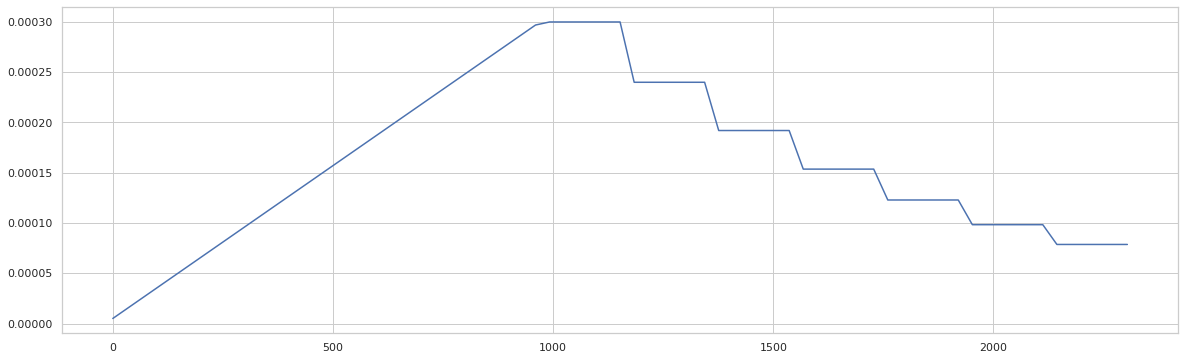

In [8]:
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights('last_' + model_path)

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1
219062272/219055592 [==============================] - 3s 0us/step
Epoch 1/12
194/194 - 87s - auc: 0.7220 - loss: 1.0140 - val_auc: 0.7791 - val_loss: 0.2776
Epoch 2/12
194/194 - 52s - auc: 0.8470 - loss: 0.5199 - val_auc: 0.8088 - val_loss: 0.7455
Epoch 3/12
194/194 - 51s - auc: 0.8532 - loss: 0.5175 - val_auc: 0.8112 - val_loss: 0.4484
Epoch 4/12
194/194 - 46s - auc: 0.8778 - loss: 0.4778 - val_auc: 0.7881 - val_loss: 1.5193
Epoch 5/12
194/194 - 46s - auc: 0.8862 - loss: 0.4630 - val_auc: 0.7417 - val_loss: 11.1022
Epoch 6/12
194/194 - 46s - auc: 0.8877 - loss: 0.4564 - val_auc: 0.7576 - val_loss: 1.5265
Epoch 7/12
194/194 - 52s - auc: 0.9074 - loss: 0.4263 - val_auc: 0.8591 - val_loss: 0.2855
Epoch 8/12
194/194 - 51s - auc: 0.9261 - loss: 0.3895 - val_auc: 0.8604 - val_loss: 0.3378
Epoch 9/12
194/194 - 46s - auc: 0.9394 - loss: 0.3583 - val_auc: 0.8368 - val_loss: 0.4446
Epoch 10/12
194/194 - 51s - auc: 0.9498 - loss: 0.3450 - val_auc: 0.8646 - val_loss: 0.3962
Epoch 11/12


## Model loss graph

Fold: 1


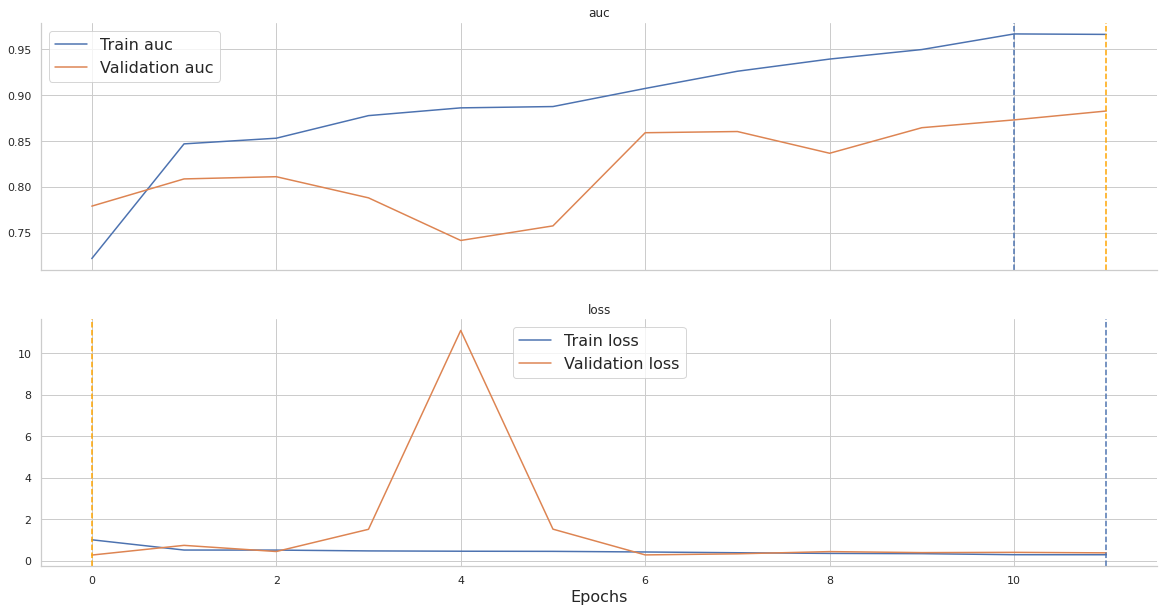

Fold: 2


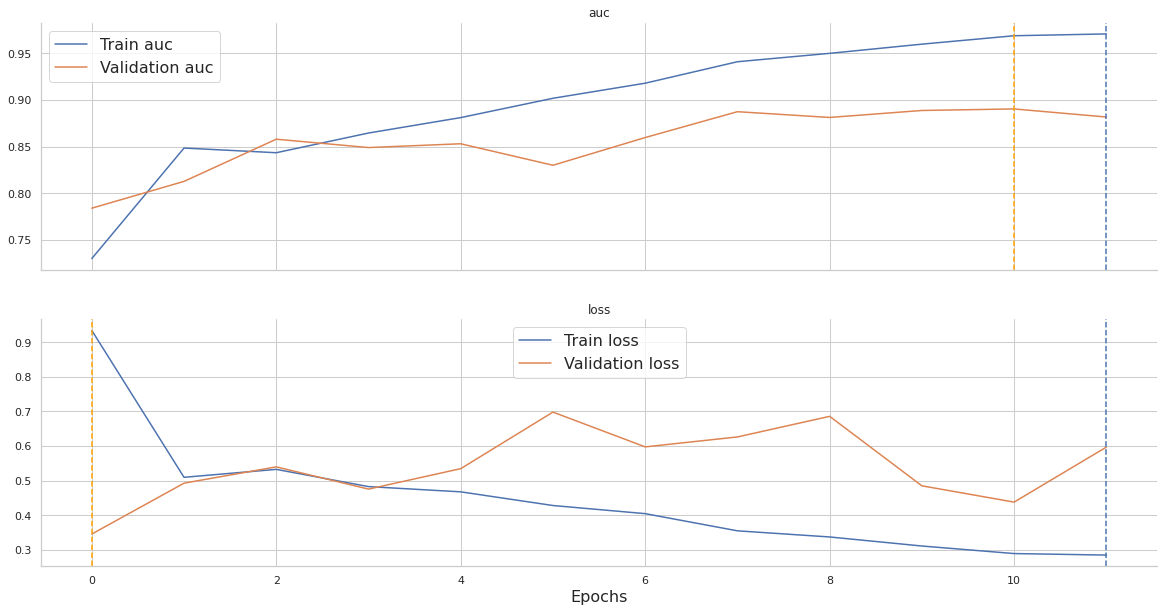

Fold: 3


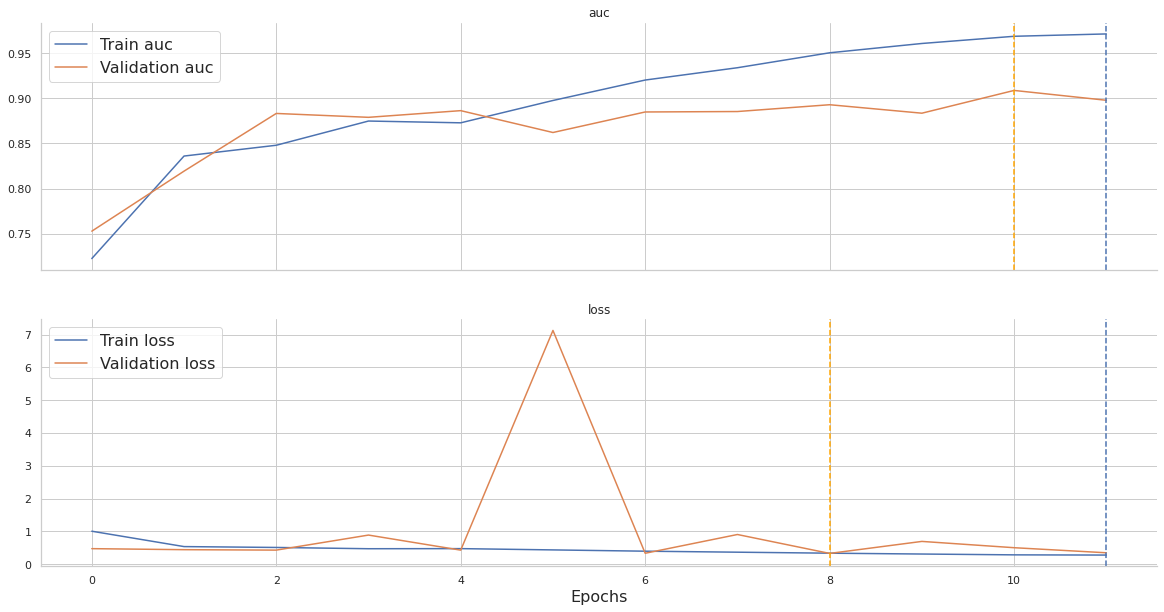

Fold: 4


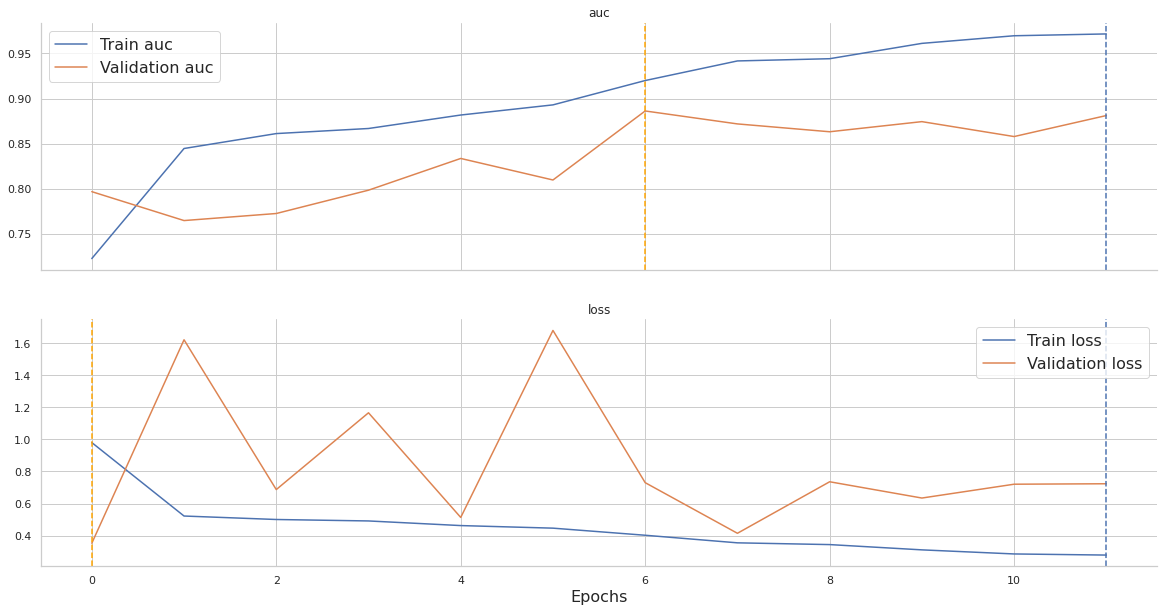

Fold: 5


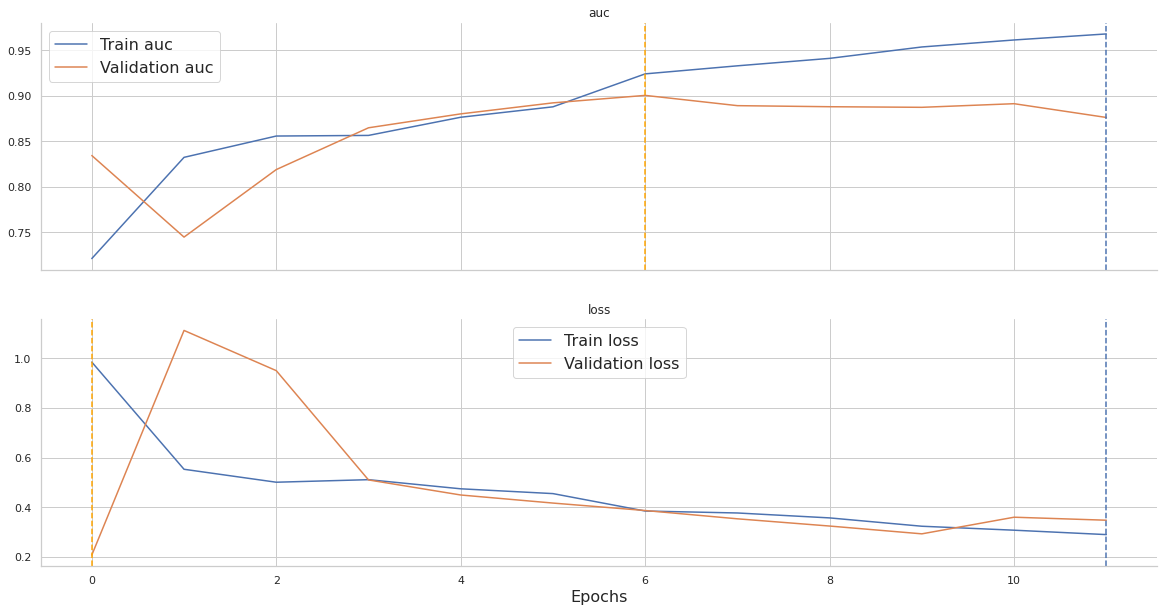

In [12]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

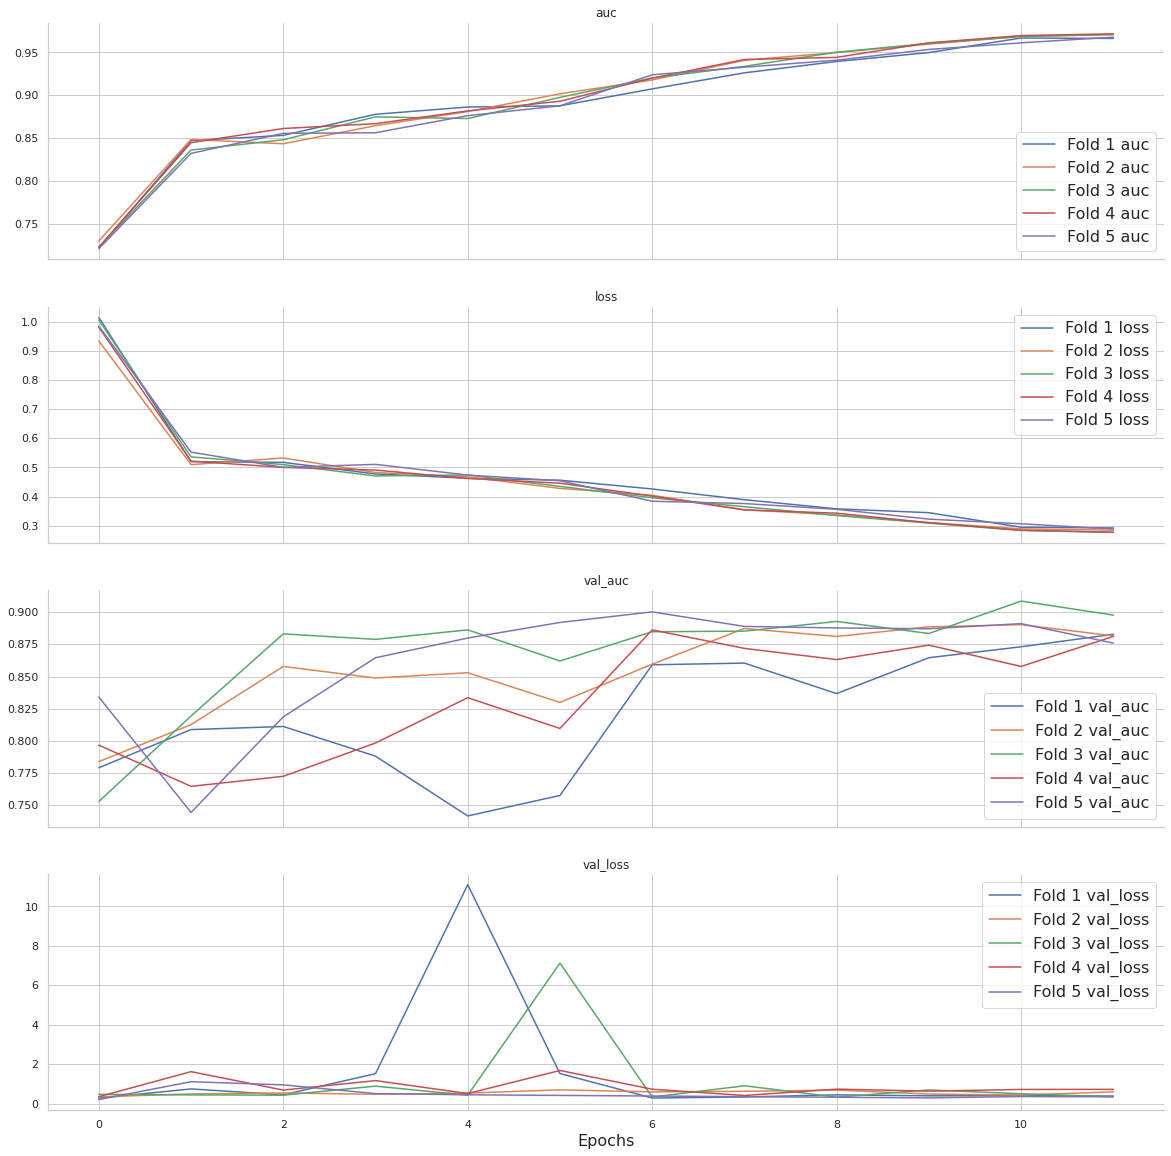

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (last)

In [14]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.976884,0.883795,0.093089,0.976947,0.884059,0.970626,0.880296,0.981010,0.897255,0.967351,0.881403,0.988485,0.875961
Accuracy,0.898089,0.885618,0.012471,0.899324,0.888580,0.869803,0.847578,0.930628,0.919524,0.915871,0.897630,0.874819,0.874779
Precision,0.151691,0.099191,0.052500,0.148566,0.098563,0.118964,0.081081,0.197574,0.130019,0.169554,0.095827,0.123797,0.090465
Recall,0.984512,0.651548,0.332964,0.981941,0.680851,0.997890,0.736364,0.968153,0.601770,0.974576,0.553571,1.000000,0.685185
F1-score,0.261603,0.171062,0.090541,0.258084,0.172197,0.212584,0.146078,0.328176,0.213836,0.288854,0.163373,0.220319,0.159827
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.976884,0.883795,0.093089,0.976947,0.884059,0.970626,0.880296,0.981010,0.897255,0.967351,0.881403,0.988485,0.875961
male,0.973693,0.880734,0.092960,0.978549,0.895129,0.966980,0.861693,0.981237,0.920270,0.953431,0.863727,0.988269,0.862850
female,0.980024,0.882582,0.097442,0.974352,0.867619,0.974543,0.909547,0.980830,0.847049,0.982049,0.897840,0.988348,0.890858
head/neck,0.972833,0.847264,0.125569,0.965266,0.849884,0.976760,0.790743,0.982671,0.929412,0.956174,0.848190,0.983294,0.818089
upper extremity,0.984750,0.905924,0.078826,0.987773,0.934840,0.977219,0.899071,0.987297,0.902778,0.979576,0.909339,0.991888,0.883593
lower extremity,0.981018,0.837024,0.143995,0.982671,0.805240,0.973327,0.848022,0.985455,0.841769,0.974556,0.900012,0.989082,0.790075
torso,0.973508,0.898473,0.075035,0.972807,0.897554,0.968672,0.913889,0.976331,0.911853,0.961898,0.861086,0.987830,0.907981
0 <= age < 26,0.968135,0.849700,0.118435,0.958021,0.934266,0.954855,0.752900,0.974306,0.910072,0.973402,0.873362,0.980091,0.777902
26 <= age < 40,0.977935,0.855918,0.122017,0.974487,0.799881,0.970624,0.848172,0.980722,0.878382,0.974209,0.889667,0.989634,0.863485


# Model evaluation (best)

In [15]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.967108,0.894248,0.072860,0.977406,0.884407,0.973987,0.891192,0.977861,0.907291,0.943420,0.886523,0.962867,0.901826
Accuracy,0.884256,0.876893,0.007363,0.899887,0.889425,0.927990,0.909062,0.885594,0.881217,0.874568,0.868612,0.833240,0.836150
Precision,0.135782,0.097568,0.038214,0.149520,0.097612,0.191139,0.108434,0.131638,0.111801,0.114005,0.093642,0.092608,0.076350
Recall,0.959232,0.703666,0.255567,0.984199,0.666667,0.955696,0.572727,0.989384,0.796460,0.908898,0.723214,0.957983,0.759259
F1-score,0.236403,0.170655,0.065748,0.259601,0.170290,0.318565,0.182344,0.232361,0.196078,0.202597,0.165814,0.168889,0.138748
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.967108,0.894248,0.072860,0.977406,0.884407,0.973987,0.891192,0.977861,0.907291,0.943420,0.886523,0.962867,0.901826
male,0.963358,0.894600,0.068758,0.979043,0.895283,0.973030,0.880114,0.978296,0.930653,0.927793,0.861945,0.958627,0.905002
female,0.970659,0.888344,0.082315,0.974763,0.868514,0.974873,0.906726,0.977691,0.858362,0.958712,0.912364,0.967256,0.895754
head/neck,0.958221,0.860905,0.097316,0.965184,0.851395,0.979023,0.817688,0.977163,0.921981,0.912474,0.860055,0.957263,0.853404
upper extremity,0.974036,0.914663,0.059373,0.987360,0.935031,0.977981,0.915310,0.983593,0.902015,0.950983,0.910282,0.970264,0.910679
lower extremity,0.969586,0.851832,0.117754,0.983159,0.804978,0.976275,0.841972,0.983603,0.881572,0.950597,0.885766,0.954295,0.844871
torso,0.965376,0.906273,0.059103,0.973521,0.897824,0.972847,0.925638,0.973576,0.916776,0.942246,0.874517,0.964688,0.916609
0 <= age < 26,0.955216,0.871036,0.084180,0.958111,0.932168,0.966332,0.791763,0.964301,0.902278,0.948157,0.865502,0.939179,0.863467
26 <= age < 40,0.965317,0.864148,0.101169,0.974734,0.800982,0.971357,0.861838,0.977687,0.884749,0.936578,0.857690,0.966227,0.915480


# Confusion matrix

Fold: 1


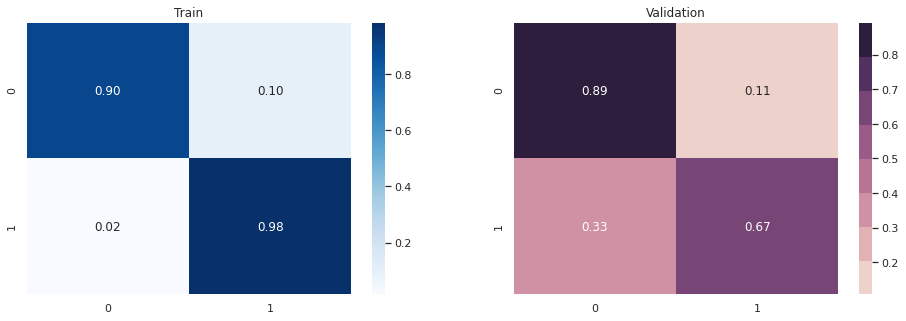

Fold: 2


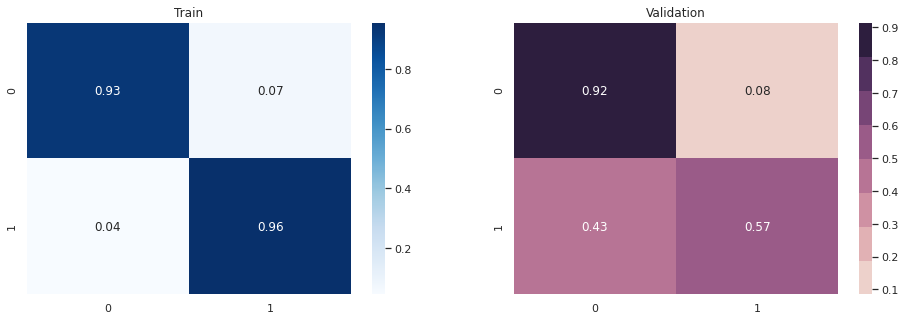

Fold: 3


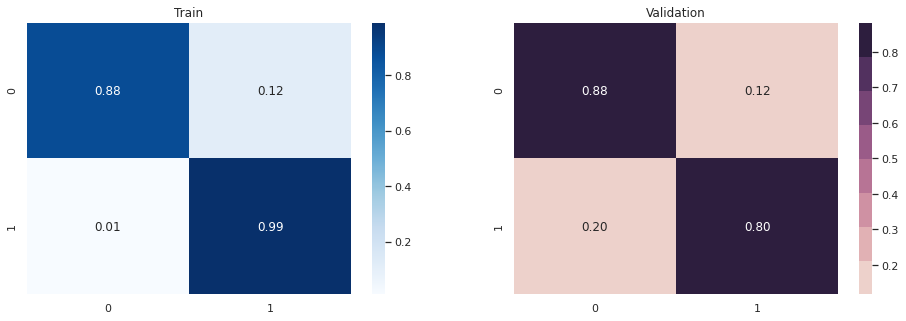

Fold: 4


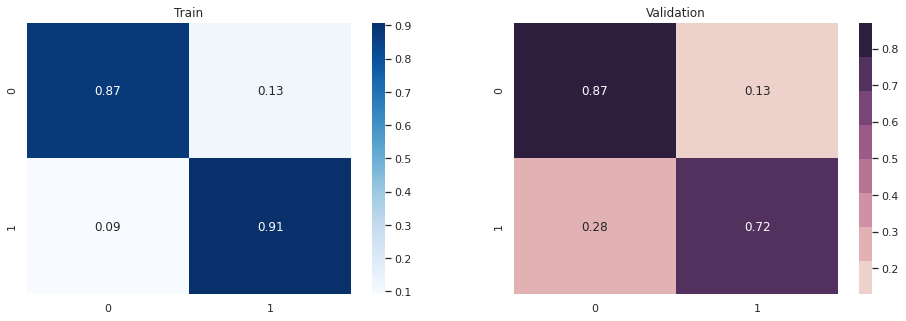

Fold: 5


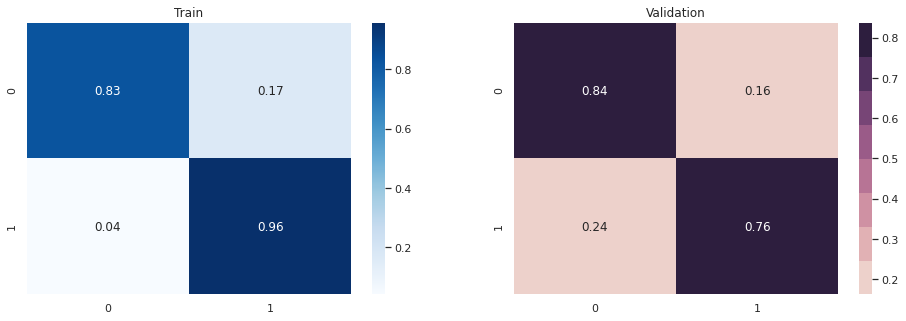

In [16]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [17]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 2996
Train positive correct predictions: 584
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.038531,0.009568,0.099244,0.036186,0.022764,0.024893
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.011315,0.011730,0.013179,0.003859,0.015170,0.012636
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.023376,0.006310,0.082792,0.008911,0.011342,0.007524
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.335332,0.337911,0.404576,0.272105,0.167477,0.494590
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.017558,0.011703,0.018190,0.022323,0.025403,0.010170
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.017260,0.005702,0.020681,0.032930,0.006717,0.020267
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.040410,0.039846,0.050625,0.031043,0.038229,0.042309
7,ISIC_0075663,female,35.0,torso,unknown,0,0.067695,0.070365,0.141368,0.022133,0.072871,0.031738
8,ISIC_0075914,male,30.0,torso,unknown,0,0.014555,0.020096,0.007183,0.015312,0.016507,0.013676
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.040919,0.013298,0.084852,0.021870,0.045825,0.038751


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.783461,0.031993,0.963484,0.963554,0.990213,0.968062
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.840630,0.493144,0.921609,0.927192,0.899914,0.961293
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.857707,0.987130,0.983055,0.458499,0.875193,0.984658
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.573905,0.141006,0.812223,0.220204,0.811232,0.884862
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.899610,0.858975,0.966647,0.782200,0.922916,0.967311
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.905895,0.923224,0.962857,0.932269,0.751597,0.959528
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.845241,0.613650,0.848230,0.914122,0.958090,0.892112
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.903385,0.881686,0.990698,0.765878,0.945664,0.932999
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.934052,0.947632,0.907598,0.933202,0.947415,0.934413
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.762874,0.595810,0.913545,0.461374,0.917219,0.926424


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.624912,0.809336,0.879658,0.477035,0.289048,0.669483
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.783461,0.031993,0.963484,0.963554,0.990213,0.968062
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.570135,0.888172,0.501652,0.432067,0.510177,0.518606
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.647275,0.601184,0.826015,0.407982,0.718378,0.682816
131,ISIC_0160455,male,75.0,lower extremity,nevus,0,0.641173,0.830094,0.884478,0.581824,0.185894,0.723576
134,ISIC_0162627,male,25.0,lower extremity,unknown,0,0.637867,0.999616,1.000000,0.090714,1.000000,0.099005
137,ISIC_0163110,female,40.0,torso,nevus,0,0.603673,0.455237,0.519970,0.496875,0.791260,0.755023
166,ISIC_0170059,female,60.0,lower extremity,unknown,0,0.851877,0.969717,0.969011,0.547412,0.823912,0.949333
168,ISIC_0170285,female,45.0,upper extremity,unknown,0,0.689520,0.692786,0.742828,0.883351,0.213215,0.915420
172,ISIC_0170676,male,75.0,upper extremity,unknown,0,0.529449,0.873465,0.400224,0.080293,0.493890,0.799372


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1244|9738
Test predictions (last) 1112|9870
Test predictions (tta) 1293|9689
Test predictions (last tta) 1157|9825
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.231446,0.232364,0.222741,0.223274
1,ISIC_0052349,male,40.0,lower extremity,0.010147,0.013087,0.007109,0.011173
2,ISIC_0058510,female,55.0,torso,0.008026,0.012480,0.009009,0.016296
3,ISIC_0073313,female,50.0,torso,0.022806,0.025544,0.021982,0.025963
4,ISIC_0073502,female,45.0,lower extremity,0.124919,0.129227,0.195122,0.123926
5,ISIC_0074618,male,50.0,lower extremity,0.040524,0.068194,0.150570,0.185698
6,ISIC_0076801,male,45.0,upper extremity,0.048427,0.073656,0.101240,0.085815
7,ISIC_0077586,male,50.0,lower extremity,0.110939,0.081886,0.098689,0.102515
8,ISIC_0082004,female,45.0,torso,0.208959,0.178018,0.226857,0.156554
9,ISIC_0082785,male,65.0,lower extremity,0.135851,0.070596,0.120362,0.088492


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.541336,0.602516,0.514090,0.569371
19,ISIC_0099348,female,45.0,upper extremity,0.513251,0.476491,0.496224,0.482385
22,ISIC_0105104,male,40.0,torso,0.615176,0.734341,0.457377,0.560423
24,ISIC_0112420,female,65.0,torso,0.931306,0.873829,0.920875,0.865909
42,ISIC_0155983,male,70.0,torso,0.710025,0.769821,0.660805,0.727292
45,ISIC_0161963,male,35.0,upper extremity,0.627534,0.657902,0.684158,0.705657
56,ISIC_0169906,male,85.0,torso,0.838617,0.795114,0.830460,0.800450
57,ISIC_0171865,male,65.0,palms/soles,0.702389,0.558874,0.768069,0.632811
61,ISIC_0175798,female,55.0,torso,0.628756,0.545555,0.662626,0.581639
64,ISIC_0178235,female,70.0,lower extremity,0.785232,0.722022,0.817797,0.665318


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.541336,0.602516,0.514090,0.569371
22,ISIC_0105104,male,40.0,torso,0.615176,0.734341,0.457377,0.560423
24,ISIC_0112420,female,65.0,torso,0.931306,0.873829,0.920875,0.865909
42,ISIC_0155983,male,70.0,torso,0.710025,0.769821,0.660805,0.727292
45,ISIC_0161963,male,35.0,upper extremity,0.627534,0.657902,0.684158,0.705657
47,ISIC_0165230,female,35.0,torso,0.357847,0.549022,0.323153,0.588382
56,ISIC_0169906,male,85.0,torso,0.838617,0.795114,0.830460,0.800450
57,ISIC_0171865,male,65.0,palms/soles,0.702389,0.558874,0.768069,0.632811
61,ISIC_0175798,female,55.0,torso,0.628756,0.545555,0.662626,0.581639
64,ISIC_0178235,female,70.0,lower extremity,0.785232,0.722022,0.817797,0.665318


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv('submission_tta.csv', index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv('submission_tta_last.csv', index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv('submission_blend_tta.csv', index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.231446,0.232364,0.231905,0.222741,0.223274,0.223008
1,ISIC_0052349,0.010147,0.013087,0.011617,0.007109,0.011173,0.009141
2,ISIC_0058510,0.008026,0.012480,0.010253,0.009009,0.016296,0.012652
3,ISIC_0073313,0.022806,0.025544,0.024175,0.021982,0.025963,0.023973
4,ISIC_0073502,0.124919,0.129227,0.127073,0.195122,0.123926,0.159524
5,ISIC_0074618,0.040524,0.068194,0.054359,0.150570,0.185698,0.168134
6,ISIC_0076801,0.048427,0.073656,0.061041,0.101240,0.085815,0.093527
7,ISIC_0077586,0.110939,0.081886,0.096413,0.098689,0.102515,0.100602
8,ISIC_0082004,0.208959,0.178018,0.193489,0.226857,0.156554,0.191705
9,ISIC_0082785,0.135851,0.070596,0.103224,0.120362,0.088492,0.104427


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.178934,0.169839,0.174387,0.188479,0.179589,0.184034
std,0.226664,0.215492,0.218452,0.223580,0.213928,0.216382
min,0.004525,0.004572,0.004927,0.003583,0.006102,0.004900
25%,0.017955,0.023126,0.021302,0.022238,0.028403,0.026531
50%,0.062168,0.058543,0.065878,0.085457,0.078343,0.086092
75%,0.262530,0.242614,0.253366,0.284061,0.256814,0.269116
max,0.979108,0.974380,0.975169,0.976895,0.970389,0.973642
